# Fragile Families analyses

This notebook is Kirstie Whitaker's work in progress as we figure out how to predict each participant's score on the following measures collected at age 15:
* gpa
* grit
* materialHardship
* eviction
* layoff
* jobTraining

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.5)
sns.set_style('white')
import matplotlib.pylab as plt
%matplotlib inline
import os
import statsmodels.api as sm
from statsmodels.formula.api import ols

## 1.0 Read in the data

In [3]:
ff_data_dir = '../../../../Dropbox/FRAGILE_FAMILIES/FFChallenge/'

bg_f = os.path.join(ff_data_dir, 'background.csv')
train_f = os.path.join(ff_data_dir, 'train.csv')

In [4]:
df_bg = pd.read_csv(bg_f, low_memory=False)

In [5]:
df_train = pd.read_csv(train_f)

In [27]:
df = df_bg.merge(df_train, on='challengeID', how='left')

In [28]:
df_train.head()

,challengeID,gpa,grit,materialHardship,eviction,layoff,jobTraining
0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,3,NaN,NaN,NaN,NaN,NaN,NaN
2,6,NaN,3.50,0.090909,0.0,0.0,0.0
3,7,2.5,3.25,0.000000,0.0,0.0,0.0
4,8,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
df_train.describe()

,challengeID,gpa,grit,materialHardship,eviction,layoff,jobTraining
count,2121.000000,1165.000000,1418.000000,1459.000000,1459.000000,1277.000000,1461.000000
mean,2085.421971,2.866738,3.427539,0.103745,0.059630,0.209084,0.234771
std,1209.429502,0.665322,0.485130,0.155665,0.236881,0.406814,0.424001
min,1.000000,1.000000,1.250000,0.000000,0.000000,0.000000,0.000000
25%,1032.000000,2.500000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2110.000000,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000
75%,3109.000000,3.250000,3.750000,0.181818,0.000000,0.000000,0.000000
max,4241.000000,4.000000,4.000000,0.818182,1.000000,1.000000,1.000000


In [33]:
df.describe()

,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m5d20,m5k10,f5c6,k5f1,gpa,grit,materialHardship,eviction,layoff,jobTraining
count,4242.00000,4242.0,0.0,4242.000000,4242.000000,0.0,4242.000000,0.0,0.0,0.0,...,4242.000000,4242.0,4242.000000,4242.000000,1165.000000,1418.000000,1459.000000,1459.000000,1277.000000,1461.000000
mean,2121.50000,-3.0,NaN,-0.376238,34.397218,NaN,0.777228,NaN,NaN,NaN,...,0.257661,-3.0,0.545733,5.829090,2.866738,3.427539,0.103745,0.059630,0.209084,0.234771
std,1224.70425,0.0,NaN,1.211390,13.497759,NaN,0.440916,NaN,NaN,NaN,...,5.647696,0.0,5.811929,6.086473,0.665322,0.485130,0.155665,0.236881,0.406814,0.424001
min,1.00000,-3.0,NaN,-9.000000,-9.000000,NaN,-9.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,-3.000000,1.000000,1.250000,0.000000,0.000000,0.000000,0.000000
25%,1061.25000,-3.0,NaN,0.000000,30.000000,NaN,1.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,-3.000000,2.500000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2121.50000,-3.0,NaN,0.000000,35.000000,NaN,1.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,9.566678,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000
75%,3181.75000,-3.0,NaN,0.000000,45.000000,NaN,1.000000,NaN,NaN,NaN,...,6.260353,-3.0,8.527483,10.035491,3.250000,3.750000,0.181818,0.000000,0.000000,0.000000
max,4242.00000,-3.0,NaN,5.000000,59.000000,NaN,1.000000,NaN,NaN,NaN,...,10.564085,-3.0,10.972726,12.466166,4.000000,4.000000,0.818182,1.000000,1.000000,1.000000


## 2.0 Find the (one) measure that best predicts each outcome 

Note: I ***know*** that this is a silly idea! It's just a simple test to see how well we can do without actually including anything special at all in the analysis design.

### 2.1 GPA

In [ ]:
results_df = {}

# Loop over the columns 
for col in df.columns[1:]:
    
    stats_df = df.loc[(df['gpa'].notnull()) 
                      & (df[col].notnull())
                      & (df[col]>-9), ['gpa', col, 'challengeID']]
    
    #print(stats_df.describe())
    
    # If there's no data then don't fit a model!
    n = len(stats_df['challengeID'])
    
    if n > 3:
        model = ols("gpa ~ {}".format(col), data=stats_df)

        result = model.fit()
        
        #print(result.summary())
        
        results_df[col] = result.rsquared
        #pred_df = df.loc[(df[col].notnull()), [col, 'challengeID']]
        
        #gpa_pred = result.predict(exog=pred_df)
        
        #print(len(gpa_pred))
        
        

In [ ]:
results_df

In [68]:
result.predict(x2)

C:\ProgramData\Anaconda3\lib\site-packages\patsy\eval.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return d[key]


PatsyError: Error evaluating factor: IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
    gpa ~ m1lenmin
          ^^^^^^^^

In [12]:
df.columns

Index(['challengeID', 'm1intmon', 'm1intyr', 'm1lenhr', 'm1lenmin', 'cm1twoc',
       'cm1fint', 'cm1tdiff', 'cm1natsm', 'm1natwt',
       ...
       'm5d20', 'm5k10', 'f5c6', 'k5f1', 'gpa', 'grit', 'materialHardship',
       'eviction', 'layoff', 'jobTraining'],
      dtype='object', length=12949)

In [37]:
result.predict?

In [26]:
df.describe()

,challengeID,m1intmon,m1intyr,m1lenhr,m1lenmin,cm1twoc,cm1fint,cm1tdiff,cm1natsm,m1natwt,...,m5d20,m5k10,f5c6,k5f1,gpa,grit,materialHardship,eviction,layoff,jobTraining
count,2121.000000,2121.0,0.0,2121.000000,2121.000000,0.0,2121.000000,0.0,0.0,0.0,...,2121.000000,2121.0,2121.000000,2121.000000,1165.000000,1418.000000,1459.000000,1459.000000,1277.000000,1461.000000
mean,2085.421971,-3.0,NaN,-0.410184,34.450259,NaN,0.776521,NaN,NaN,NaN,...,0.235716,-3.0,0.473135,5.764640,2.866738,3.427539,0.103745,0.059630,0.209084,0.234771
std,1209.429502,0.0,NaN,1.237988,13.546966,NaN,0.464834,NaN,NaN,NaN,...,5.622805,0.0,5.774013,6.111113,0.665322,0.485130,0.155665,0.236881,0.406814,0.424001
min,1.000000,-3.0,NaN,-9.000000,-9.000000,NaN,-9.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,-3.000000,1.000000,1.250000,0.000000,0.000000,0.000000,0.000000
25%,1032.000000,-3.0,NaN,0.000000,30.000000,NaN,1.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,-3.000000,2.500000,3.000000,0.000000,0.000000,0.000000,0.000000
50%,2110.000000,-3.0,NaN,0.000000,35.000000,NaN,1.000000,NaN,NaN,NaN,...,-3.000000,-3.0,-3.000000,9.566678,3.000000,3.500000,0.000000,0.000000,0.000000,0.000000
75%,3109.000000,-3.0,NaN,0.000000,45.000000,NaN,1.000000,NaN,NaN,NaN,...,-3.000000,-3.0,8.282405,10.035491,3.250000,3.750000,0.181818,0.000000,0.000000,0.000000
max,4241.000000,-3.0,NaN,5.000000,59.000000,NaN,1.000000,NaN,NaN,NaN,...,10.564085,-3.0,10.972726,12.113727,4.000000,4.000000,0.818182,1.000000,1.000000,1.000000


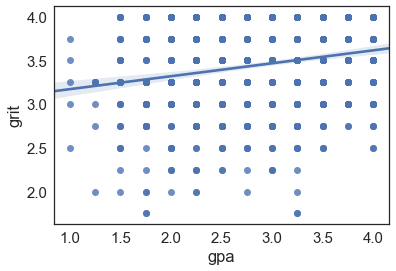

In [33]:
sns.regplot(df_train['gpa'], df_train['grit'])

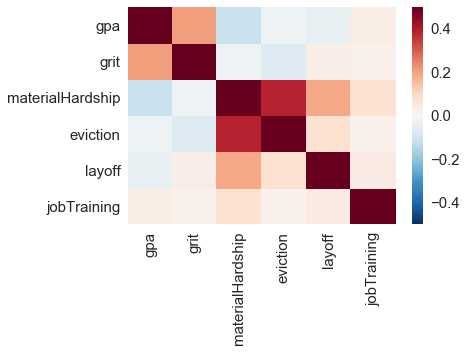

In [38]:
sns.heatmap(df_train.iloc[:,1:].corr(), vmin=-0.5, vmax=0.5)